In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import json
import sys

sys.path.insert(1, '../')
from MasterPlot_Functions import *

home_dir = '/nfs/a319/gy17m2a/PhD/'

In [2]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)

present=df_long[df_long['Climate']=='Present'].copy()
future=df_long[df_long['Climate']=='Future'].copy()

In [3]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")

In [4]:
df_changes_noNan = df_changes_all.dropna()

## Testing statistical significance between distributions of D50 in the present and future
### Is there a statistically significant difference between the distribution of values across all events and all gauges, and all EMs?

In [5]:
# Perform KS test
ks_stat, p_value = ks_2samp(present['D50_new'], future['D50_new'])

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.006697886131800002
P-value: 9.536354192233076e-21
The distributions are significantly different.


### Is there a statistically significant difference between the events at each gauge (for a particular duration) between present and future?

In [31]:
sig_diff = 0
non_sig_diff = 0

diffs_dict={}
gauge_nums=[]

for dur in ['All', 1,6,24]:
    print(dur)
    present_data = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(dur) in x or x == str(dur))]
    future_data = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(dur) in x or x == str(dur))]
    
    if dur == 'All':
        present_data = present
        future_data = future
    
    diff = []
    for gauge_num in range(0,1294):
        if gauge_num not in [444,827,888]:
            if dur == 1:
                gauge_nums.append(gauge_num)

            this_g_present = present_data[present_data['gauge_num'] == gauge_num]
            this_g_future = future_data[future_data['gauge_num'] == gauge_num]
            
            data1 = this_g_present["theta"].values  # The present data (e.g., theta for present)
            data2 = this_g_future["theta"].values  # The future data (e.g., theta for future)
            
            # Perform bootstrap test to calculate p-value
            observed_V, p_value = bootstrap_kuipers_test(data1, data2, n_bootstrap=1000)
            if p_value > 0.05:
                significant= 'Not significant'
            else:
                significant = 'Significant'
            print("Gauge: ", gauge_num, round(observed_V,1), p_value, significant)
            
            observed_V, critical_value, p_value = critical_value_kuipers_test(data1, data2, n_simulations=1000, alpha=0.05)
            if observed_V > critical_value:
                significant='Significant'
            else:
                significant = 'Not significant'
            print("Gauge: ", gauge_num, round(observed_V,1), p_value, significant)
#             # Perform KS test
#             ks_stat, p_value = ks_2samp(this_g_present['D'], this_g_future['D'])
            
#             if p_value < 0.05:
#                 # print(gauge_num, "The distributions are significantly different.")
#                 # print('')
#                 sig_diff = sig_diff +1
#                 diff.append(1)
#             else:
#                 non_sig_diff = non_sig_diff +1
#                 diff.append(0) 
#         #         print(gauge_num, "The distributions are not significantly different.")
#     diffs_dict[dur]=diff

All
Gauge:  0 0.2 0.752 Not significant
Gauge:  0 0.2 0.007 Significant
Gauge:  1 0.3 0.556 Not significant
Gauge:  1 0.3 0.0 Significant
Gauge:  2 0.2 0.697 Not significant
Gauge:  2 0.2 0.004 Significant
Gauge:  3 0.2 0.51 Not significant
Gauge:  3 0.2 0.0 Significant
Gauge:  4 0.2 0.654 Not significant
Gauge:  4 0.2 0.001 Significant
Gauge:  5 0.3 0.527 Not significant
Gauge:  5 0.3 0.0 Significant
Gauge:  6 0.1 0.589 Not significant
Gauge:  6 0.1 0.04 Significant


KeyboardInterrupt: 

In [ ]:
def bootstrap_kuipers_test(data1, data2, n_bootstrap=5000):
    # Compute the original Kuiper statistic
    observed_V, _, _ = two_sample_kuipers_test_diff_lengths(data1, data2)

    # Initialize list to store bootstrap statistics
    bootstrap_Vs = []

    # Perform resampling and compute the Kuiper statistic for each resample
    for _ in range(n_bootstrap):
        # Resample both datasets with replacement
        resample1 = np.random.choice(data1, size=len(data1), replace=True)
        resample2 = np.random.choice(data2, size=len(data2), replace=True)
        
        # Calculate the Kuiper statistic for the resampled datasets
        V, _, _ = two_sample_kuipers_test_diff_lengths(resample1, resample2)
        bootstrap_Vs.append(V)

    # Calculate the p-value: the proportion of bootstrap statistics greater than or equal to the observed statistic
    p_value = np.sum(np.array(bootstrap_Vs) >= observed_V) / n_bootstrap

    return observed_V, p_value

def critical_value_kuipers_test(data1, data2, n_simulations=5000, alpha=0.05):
    # Compute the original Kuiper statistic
    observed_V, _, _ = two_sample_kuipers_test_diff_lengths(data1, data2)

    # Initialize list to store Kuiper statistics from the null distribution
    null_distribution = []

    # Combine both datasets to simulate under the null hypothesis (no difference)
    combined_data = np.concatenate([data1, data2])

    # Perform simulations by resampling from the combined data
    for _ in range(n_simulations):
        # Randomly shuffle combined data and split into two new datasets
        np.random.shuffle(combined_data)
        simulated_data1 = combined_data[:len(data1)]
        simulated_data2 = combined_data[len(data1):]

        # Calculate the Kuiper statistic for the simulated datasets
        simulated_V, _, _ = two_sample_kuipers_test_diff_lengths(simulated_data1, simulated_data2)
        null_distribution.append(simulated_V)

    # Calculate the critical value at the desired alpha level (e.g., 95th percentile)
    critical_value = np.percentile(null_distribution, 100 * (1 - alpha))

    # Compare observed statistic to critical value
    p_value = np.sum(np.array(null_distribution) >= observed_V) / n_simulations

    return observed_V, critical_value, p_value


In [34]:
n_simulations = 5000
n_bootstrap = 5000

for dur in ['All']:
    print(dur)
    present_data = present[present['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(dur) in x or x == str(dur))]
    future_data = future[future['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(dur) in x or x == str(dur))]
    
    if dur == 'All':
        present_data = present
        future_data = future
    
    diff = []
    for gauge_num in range(10,1294):
        if gauge_num not in [444,827,888]:
            if dur == 1:
                gauge_nums.append(gauge_num)

            this_g_present = present_data[present_data['gauge_num'] == gauge_num]
            this_g_future = future_data[future_data['gauge_num'] == gauge_num]
            
            data1 = this_g_present["theta"].values  # The present data (e.g., theta for present)
            data2 = this_g_future["theta"].values  # The future data (e.g., theta for future)
            
            # Assuming your data is loaded in data1 (present) and data2 (future)
            np.random.seed(42)  # For reproducibility

            # Perform Critical Value Test
            observed_V, critical_value, p_value_critical = critical_value_kuipers_test(data1, data2, n_simulations=5000, alpha=0.05)
            print(gauge_num)
            print(f"Critical Value Test - Observed V: {observed_V}, Critical Value: {critical_value}, p-value: {p_value_critical}")

            # Perform Bootstrap Test
            observed_V_bootstrap, p_value_bootstrap = bootstrap_kuipers_test(data1, data2, n_bootstrap=5000)
            print(f"Bootstrap Test - Observed V: {observed_V_bootstrap}, p-value: {p_value_bootstrap}")

            # Interpret the results
            if p_value_critical < 0.05 and p_value_bootstrap < 0.05:
                print("The difference between the datasets is significant.")
            else:
                print("The difference between the datasets is not significant.")


All
10
Critical Value Test - Observed V: 0.18973290416834088, Critical Value: 0.12939296904019204, p-value: 0.0012
Bootstrap Test - Observed V: 0.18973290416834088, p-value: 0.5926
The difference between the datasets is not significant.
11
Critical Value Test - Observed V: 0.1278957148488089, Critical Value: 0.12766005968804572, p-value: 0.05
Bootstrap Test - Observed V: 0.1278957148488089, p-value: 0.8172
The difference between the datasets is not significant.
12
Critical Value Test - Observed V: 0.17800184736068575, Critical Value: 0.12992891149807598, p-value: 0.0034
Bootstrap Test - Observed V: 0.17800184736068575, p-value: 0.6328
The difference between the datasets is not significant.
13
Critical Value Test - Observed V: 0.15661963448805993, Critical Value: 0.12706664682884086, p-value: 0.0082
Bootstrap Test - Observed V: 0.15661963448805993, p-value: 0.615
The difference between the datasets is not significant.
14
Critical Value Test - Observed V: 0.0982800982800982, Critical Val

KeyboardInterrupt: 

In [18]:
import numpy as np
import scipy.stats as stats


def modified_kuipers_test(data, cdf_function, *args):
    """
    Performs a Modified Kuiper's Test to compare the distribution of `data` with a theoretical CDF.

    Parameters:
    data : array-like
        Observed data values (sorted in ascending order).
    cdf_function : callable
        A function representing the theoretical CDF to compare against.
    *args : additional arguments
        Parameters to pass to the CDF function (e.g., mean and variance for normal distribution).

    Returns:
    V : float
        The Kuiper statistic.
    D_plus : float
        Maximum positive deviation.
    D_minus : float
        Maximum negative deviation.
    """
    # Sort data
    data = np.sort(data)
    n = len(data)
    
    # Compute ECDF
    ecdf = np.arange(1, n + 1) / n
    
    # Compute theoretical CDF values
    theoretical_cdf = np.array([cdf_function(x, *args) for x in data])
    
    # Compute D+ and D-
    D_plus = np.max(ecdf - theoretical_cdf)
    D_minus = np.max(theoretical_cdf - ecdf)
    
    # Kuiper statistic
    V = D_plus + D_minus
    
    # Return results
    return V, D_plus, D_minus


# Example: Compare data to a uniform distribution
data = np.random.uniform(0, 1, size=100)
V, D_plus, D_minus = modified_kuipers_test(this_g_present["theta"], stats.uniform.cdf)
print(f"Kuiper Statistic: {V}, D+: {D_plus}, D-: {D_minus}")


Kuiper Statistic: 0.8583690987124464, D+: 0.0, D-: 0.8583690987124464


In [17]:
this_g_present["theta"].max()

6.227277429702971

In [9]:
df = pd.DataFrame({'gauge_num':gauge_nums, 'Sig_Diff_1h':np.array(diffs_dict[1]),
                'Sig_Diff_6h':np.array(diffs_dict[6]), 'Sig_Diff_24h':np.array(diffs_dict[24]),
                  'Sig_Diff_All':np.array(diffs_dict['All'])})

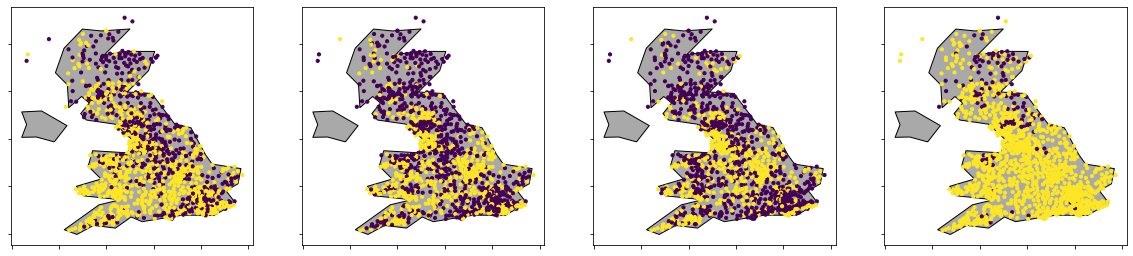

In [10]:
fig,axs=plt.subplots(ncols=4, figsize=(20,10))
plot_values_on_map(axs[0], df, 'All', tbo_vals, 
                   'Sig_Diff_1h', vmin=0, vmax=1,)
plot_values_on_map(axs[1], df, 'All', tbo_vals, 
                   'Sig_Diff_6h', vmin=0, vmax=1,)
plot_values_on_map(axs[2], df, 'All', tbo_vals, 
                   'Sig_Diff_24h', vmin=0, vmax=1,)
plot_values_on_map(axs[3], df, 'All', tbo_vals, 
                   'Sig_Diff_All', vmin=0, vmax=1,)

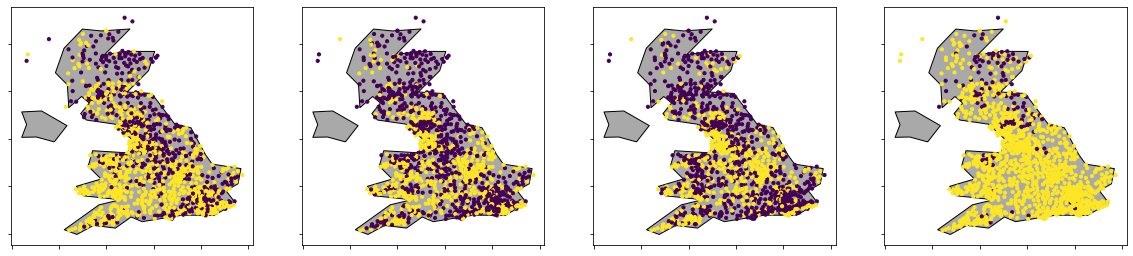

In [11]:
fig,axs=plt.subplots(ncols=4, figsize=(20,10))
plot_values_on_map(axs[0], df, 'All', tbo_vals, 
                   'Sig_Diff_1h', vmin=0, vmax=1,)
plot_values_on_map(axs[1], df, 'All', tbo_vals, 
                   'Sig_Diff_6h', vmin=0, vmax=1,)
plot_values_on_map(axs[2], df, 'All', tbo_vals, 
                   'Sig_Diff_24h', vmin=0, vmax=1,)
plot_values_on_map(axs[3], df, 'All', tbo_vals, 
                   'Sig_Diff_All', vmin=0, vmax=1,)

Text(0.5, 0, 'Difference in median D50')

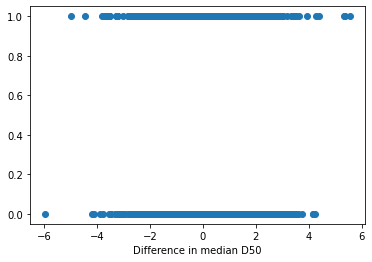

In [12]:
plt.scatter(df_changes_all['D50_median_diff'], df['Sig_Diff_6h'])
plt.xlabel('Difference in median D50')

### Is there a statistically signfiicant difference between the mean values at each gauge?

In [13]:
# Assuming you have columns for present and future D50 values
present_D50 = df_changes_noNan['D50_mean_present']  # Column with present D50 values
future_D50 = df_changes_noNan['D50_mean_future']  # Column with future D50 values

# Perform a paired t-test to assess if the change is significant
t_stat, p_value = stats.ttest_rel(present_D50, future_D50)
t_stat, p_value

(-8.460680194817018, 7.115425472139616e-17)

In [14]:
# Perform KS test
ks_stat, p_value = ks_2samp(df_changes_noNan['D50_mean_present'], df_changes_noNan['D50_mean_future'])

print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")

KS Statistic: 0.11773818745158791
P-value: 3.2642278070130653e-08
The distributions are significantly different.


### Is there a statistically signfiicant difference between the mean values at each gauge? One value per gauge

In [15]:
def row_t_test(row):
    t_stat, p_val = stats.ttest_ind([row['D50_mean_present']], [row['D50_mean_future']], equal_var=False)
    return pd.Series({'t_stat': t_stat, 'p_val': p_val})

# Apply the t-test row-by-row
df_changes_noNan[['t_stat', 'p_val']] = df_changes_noNan.apply(row_t_test, axis=1)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3703: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## For comparison, do we also see a significant difference between ensemble members?

In [16]:
bc005 = present[present['em']=='bc005']
bc006 = present[present['em']=='bc006']
bc007 = present[present['em']=='bc007']
bc009 = present[present['em']=='bc009']
bc010 = present[present['em']=='bc010']
bc011 = present[present['em']=='bc011']
bc013 = present[present['em']=='bc013']

### Check normality of the differences in mean D50 at each location 

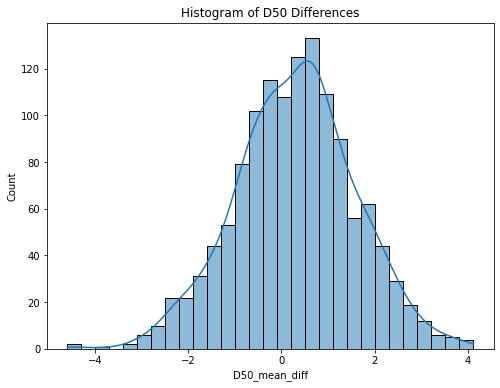

Shapiro-Wilk Test p-value: 3.1902789743298854e-08
Differences are not normally distributed. Consider using a non-parametric test.


In [20]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")

# 1. Checking for normality (visual inspection)
plt.figure(figsize=(8, 6))
sns.histplot(df_changes_all['D50_mean_diff'], kde=True)
plt.title('Histogram of D50 Differences')
plt.show()

# 2. Perform the Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(df_changes_all['D_mean_diff'])
print("Shapiro-Wilk Test p-value:", shapiro_test.pvalue)

# If p-value < 0.05, the differences are likely not normally distributed
if shapiro_test.pvalue < 0.05:
    print("Differences are not normally distributed. Consider using a non-parametric test.")
else:
    print("Differences are normally distributed.")
